In [68]:
import sympy
from sympy.plotting import plot
import sympy as sp
import penbegone as pbg
from penbegone import common as bgcom
from penbegone import plotting as bgplot
from penbegone.common import printeq

%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System definition

In [69]:
v = sp.symbols("v", positive=True)
g = sp.symbols("g", positive=True)
h = sp.symbols("h", real=True)

pitch, throttle, m = sp.symbols("theta delta_t m")
F_t, c_drag, S, rho = sp.symbols("F_t C_drag S rho")
theta_0 = sp.symbols("theta_0")
drag_ = 0.5*S*rho*v*v*c_drag
f_v_dot_ = 1/m*(sp.sin(pitch)*g + F_t*throttle - drag_)
f_h_dot_ = v*sp.sin(pitch-theta_0)  # Perhaps add effect of increasing lift as airspeed increases?

In [70]:
num_values = dict()

In [71]:
Sys = [f_v_dot_, f_h_dot_]
states = [v, h]

v_star, h_star = sp.symbols("v_star h_star")
states_tr = [v_star, h_star]

## Controller

In [72]:
h_dem, h_dem_dot, v_dem, v_dem_dot = sp.symbols("h_d h_d_dot v_d v_d_dot")
h_dot, v_c, v_dot = sp.symbols("hdot v_cruise vdot")
v_max, v_min, climb_max, sink_max, sink_min = sp.symbols("V_max V_min hdot_cmax hdot_smax hdot_smin")
thr_max, thr_min, thr_trim = sp.symbols("t_{max} t_{min} t_{trim}")
w, k_tc, k_pd, k_i, k_td = sp.symbols("w k_tc k_pd k_i k_td", real=True)

In [73]:
STEdot_max, STEdot_min, STEdot_neg_max = sp.symbols("Edot^*_max Edot^*_min Edot^*_nmax")

STEdot_max_ = g*climb_max
STEdot_min_ = -g*sink_min
STEdot_neg_max = -g*sink_max

In [74]:
## _update_speed_demand

# Perhaps the increase of _TAS_dem when at max sink plays a role?

vel_rate_max_ = 0.5*STEdot_max_/v
vel_rate_neg_cruise = 0.9*STEdot_min_/v_c
vel_rate_neg_max = 0.9*STEdot_min_/v_max

# I can add the LPF effect of TIME_CONST here, instead of pure differentiation.
c_states = [v_dem]

In [75]:
## _update_height_demand

# Can add the LPF effect of HDEM_TCONST here, over h_dem.
c_states.append(h_dem)

In [76]:
## _update_energies

SPE_dem_ = h_dem*g
SKE_dem_ = 0.5*v_dem*v_dem
SKE_est_ = 0.5*v*v
SKE_dot_dem_= v*v_dem_dot # In the source vdot_dem_ is high-passed. How does this translate to the actual system?
SKE_dot_ = v*v_dot # Same comment as above.
SPE_est_ = h*g
SPE_dot_ = h_dot*g

In [77]:
## _update_pitch

w_k_ = w
w_p_ = 2-w

SEB_dem_ = SPE_dem_*w_p_ - SKE_dem_*w_k_
SEB_est_ = SPE_est_*w_p_ - SKE_est_*w_k_
SEB_err_ = SEB_dem_ - SEB_est_
SEB_dot_est_ = SPE_dot_*w_p_ - SKE_dot_*w_k_

SEB_dot_dem_ = SEB_err_/k_tc + h_dem_dot*g*w_p_
SEB_dot_err_ = SEB_dot_dem_ - SEB_dot_est_
SEB_dot_dem_tot_ = SEB_dot_dem_ + SEB_dot_err_*k_pd

# Adding integrator states.
SEB_dot_int = sp.symbols("x_{intsebdot}")
c_states.append(SEB_dot_int)
SEB_dot_int_dot_ = SEB_dot_err_*k_i

KE_int = sp.symbols("x_{intKE}")
c_states.append(KE_int)
KE_int_dot_ = (SKE_est_ - SKE_dem_)*w_k_/k_tc

pitch_dem_ = (SEB_dot_dem_tot_ + SEB_dot_int + KE_int) / (v * g)

In [78]:
## _update_throttle_with_airspeed

STE_error_ = SKE_dem_ - SKE_est_ + SPE_dem_ - SPE_est_
SPE_dot_dem_ = (SPE_dem_ - SPE_est_)/k_tc
STE_dot_dem_ = SPE_dot_dem_ + SKE_dot_dem_
STE_dot_err_ = STE_dot_dem_ - SKE_dot_ - SPE_dot_

K_thr2STE_ = (STEdot_max_ - STEdot_min_)/(thr_max - thr_min)
K_STE2Thr_ = 1 / (K_thr2STE_ * k_tc)
# Adding integrator state.
integTHR_state = sp.symbols("x_{intthr}")
c_states.append(integTHR_state)
integTHR_state_dot_ = STE_error_*k_i*K_STE2Thr_
ff_throttle = STE_dot_dem_/K_thr2STE_ + thr_trim

throttle_dem_ = K_STE2Thr_*(STE_error_ + STE_dot_err_*k_td) + ff_throttle + integTHR_state

In [79]:
C = {throttle: throttle_dem_, pitch: pitch_dem_}
C_d = [v_dem_dot, h_dem_dot, SEB_dot_int_dot_, KE_int_dot_, integTHR_state_dot_]

for c in C.values():
    display(c.simplify())

(g*k_tc**2*(hdot_cmax + hdot_smin)*(t_{trim} + x_{intthr}) + k_tc*(t_{max} - t_{min})*(-g*h + g*h_d + k_tc*v*v_d_dot) - (t_{max} - t_{min})*(k_tc*(g*h - g*h_d + 0.5*v**2 - 0.5*v_d**2) + k_td*(g*h - g*h_d + k_tc*(g*hdot - v*v_d_dot + v*vdot))))/(g*k_tc**2*(hdot_cmax + hdot_smin))

(g*h*(w - 2) - g*h_d*(w - 2) - k_pd*(g*h*(2 - w) - g*h_d*(2 - w) + k_tc*(g*h_d_dot*(w - 2) - g*hdot*(w - 2) - v*vdot*w) - 0.5*v**2*w + 0.5*v_d**2*w) + k_tc*(-g*h_d_dot*(w - 2) + x_{intKE} + x_{intsebdot}) + 0.5*v**2*w - 0.5*v_d**2*w)/(g*k_tc*v)

## Autonomous system

In [80]:
num_values[thr_max] = 1
num_values[thr_min] = 0
Sys = [s.subs(num_values) for s in Sys]

In [81]:
states_a = states + c_states
Sys_a = Sys + C_d

In [82]:
Sys_a = [s_i.subs(C | num_values) for s_i in Sys_a]
for k, s in zip(states_a, Sys_a):
    printeq(k, s)

Eq(v, (-0.5*C_drag*S*rho*v**2 + F_t*(t_{trim} + x_{intthr} + (v*v_d_dot + (-g*h + g*h_d)/k_tc)/(g*hdot_cmax + g*hdot_smin) + (-g*h + g*h_d + k_td*(-g*hdot + v*v_d_dot - v*vdot + (-g*h + g*h_d)/k_tc) - 0.5*v**2 + 0.5*v_d**2)/(k_tc*(g*hdot_cmax + g*hdot_smin))) + g*sin((g*h_d_dot*(2 - w) + k_pd*(g*h_d_dot*(2 - w) - g*hdot*(2 - w) + v*vdot*w + (-g*h*(2 - w) + g*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc) + x_{intKE} + x_{intsebdot} + (-g*h*(2 - w) + g*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc)/(g*v)))/m)

Eq(h, -v*sin(theta_0 - (g*h_d_dot*(2 - w) + k_pd*(g*h_d_dot*(2 - w) - g*hdot*(2 - w) + v*vdot*w + (-g*h*(2 - w) + g*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc) + x_{intKE} + x_{intsebdot} + (-g*h*(2 - w) + g*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc)/(g*v)))

Eq(v_d, v_d_dot)

Eq(h_d, h_d_dot)

Eq(x_{intsebdot}, k_i*(g*h_d_dot*(2 - w) - g*hdot*(2 - w) + v*vdot*w + (-g*h*(2 - w) + g*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc))

Eq(x_{intKE}, w*(0.5*v**2 - 0.5*v_d**2)/k_tc)

Eq(x_{intthr}, k_i*(-g*h + g*h_d - 0.5*v**2 + 0.5*v_d**2)/(k_tc*(g*hdot_cmax + g*hdot_smin)))

Trying to simplify this takes more than 3mins.

## Equilibrium points

In [83]:
num_values[g] = 9.81
num_values[rho] = 1.225

num_values[v_dot] = 0
num_values[h_dot] = 0
num_values[h_dem_dot] = 0
num_values[v_dem_dot] = 0
# num_values[h] = h_dem

var_rep = dict()
x_ipitch = sp.symbols("x_{ipitch}")
var_rep[SEB_dot_int + KE_int] = x_ipitch
Sys_a = [s.subs(var_rep) for s in Sys_a]
del Sys_a[4]
del Sys_a[4]
Sys_a.append(SEB_dot_int_dot_ + KE_int_dot_)
del states_a[4]
del states_a[4]
states_a.append(x_ipitch)
states_tr = [h_star, v_star, sp.symbols("v_{d*}"), sp.symbols("h_{d*}"), sp.symbols("x_{intthr*}"), sp.symbols("x_{ipitch*}")]

Sys_a = [s.subs(num_values) for s in Sys_a]

In [84]:
for k, s in zip(states_a, Sys_a):
    printeq(k, s)

Eq(v, (-0.6125*C_drag*S*v**2 + F_t*(t_{trim} + x_{intthr} + (-9.81*h + 9.81*h_d)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)) + (-9.81*h + 9.81*h_d - 0.5*v**2 + 0.5*v_d**2 + k_td*(-9.81*h + 9.81*h_d)/k_tc)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin))) + 9.81*sin(0.101936799184506*(k_pd*(-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc + x_{ipitch} + (-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc)/v))/m)

Eq(h, -v*sin(theta_0 - 0.101936799184506*(k_pd*(-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc + x_{ipitch} + (-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc)/v))

Eq(v_d, 0)

Eq(h_d, 0)

Eq(x_{intthr}, k_i*(-9.81*h + 9.81*h_d - 0.5*v**2 + 0.5*v_d**2)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)))

Eq(x_{ipitch}, k_i*(-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc + w*(0.5*v**2 - 0.5*v_d**2)/k_tc)

In [85]:
# e_points = sp.solve(Sys_a, states_a, dict=True)
Sys_am = [s for i, s in enumerate(Sys_a) if i in [0, 1, 4, 5] ]
states_am = [s for i, s in enumerate(states_a) if i in [0, 1, 4, 5] ]
e_points = sp.solve(Sys_am, states_am, dict=True)
e_points

[{h: h_d,
  v: -v_d,
  x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*t_{trim} - 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: -9.81*theta_0*v_d},
 {h: h_d,
  v: -v_d,
  x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*t_{trim} + 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: 9.81*v_d*(3.14159265358979 - theta_0)},
 {h: h_d,
  v: v_d,
  x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*t_{trim} - 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: 9.81*theta_0*v_d},
 {h: h_d,
  v: v_d,
  x_{intthr}: 0.0025*(245.0*C_drag*S*v_d**2 - 400.0*F_t*t_{trim} + 3924.0*sin(theta_0))/F_t,
  x_{ipitch}: 9.81*v_d*(theta_0 - 3.14159265358979)}]

In [86]:
display(Sys_am)
display(states_am)

[(-0.6125*C_drag*S*v**2 + F_t*(t_{trim} + x_{intthr} + (-9.81*h + 9.81*h_d)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)) + (-9.81*h + 9.81*h_d - 0.5*v**2 + 0.5*v_d**2 + k_td*(-9.81*h + 9.81*h_d)/k_tc)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin))) + 9.81*sin(0.101936799184506*(k_pd*(-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc + x_{ipitch} + (-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc)/v))/m,
 -v*sin(theta_0 - 0.101936799184506*(k_pd*(-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc + x_{ipitch} + (-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc)/v),
 k_i*(-9.81*h + 9.81*h_d - 0.5*v**2 + 0.5*v_d**2)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)),
 k_i*(-9.81*h*(2 - w) + 9.81*h_d*(2 - w) + 0.5*v**2*w - 0.5*v_d**2*w)/k_tc + w*(0.5*v**2 - 0.5*v_d**2)/k_tc]

[v, h, x_{intthr}, x_{ipitch}]

In [87]:
sol_idx = 2
states_trim = {k: x.simplify() for k, x in e_points[sol_idx].items()}  # Ignoring the other solutions.
for k, s in states_trim.items():
    printeq(k, s)

Eq(h, h_d)

Eq(v, v_d)

Eq(x_{intthr}, (0.6125*C_drag*S*v_d**2 - 1.0*F_t*t_{trim} - 9.81*sin(theta_0))/F_t)

Eq(x_{ipitch}, 9.81*theta_0*v_d)

In [89]:
states_trim[v_dem] = v_dem
states_trim[h_dem] = h_dem

## Translated system

In [93]:
trans_dict = dict()
for i, st in enumerate(states_a):
    trans_dict[states_a[i]] = states_tr[i] + states_trim[st]
Sys_tr = [s_i.subs(trans_dict) for s_i in Sys_a]
for s in Sys_tr:
    display(s)

(-0.6125*C_drag*S*(h_star + v_d + v_{d*})**2 + F_t*(t_{trim} + x_{intthr*} - 9.81*v_star/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)) + (-9.81*v_star + 0.5*(v_d + v_{d*})**2 - 0.5*(h_star + v_d + v_{d*})**2 - 9.81*k_td*v_star/k_tc)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin)) + (0.6125*C_drag*S*v_d**2 - 1.0*F_t*t_{trim} - 9.81*sin(theta_0))/F_t) + 9.81*sin(0.101936799184506*(k_pd*(-0.5*w*(v_d + v_{d*})**2 + 0.5*w*(h_star + v_d + v_{d*})**2 + 9.81*(2 - w)*(h_d + h_{d*}) - 9.81*(2 - w)*(h_d + h_{d*} + v_star))/k_tc + 9.81*theta_0*v_d + x_{ipitch*} + (-0.5*w*(v_d + v_{d*})**2 + 0.5*w*(h_star + v_d + v_{d*})**2 + 9.81*(2 - w)*(h_d + h_{d*}) - 9.81*(2 - w)*(h_d + h_{d*} + v_star))/k_tc)/(h_star + v_d + v_{d*})))/m

-(h_star + v_d + v_{d*})*sin(theta_0 - 0.101936799184506*(k_pd*(-0.5*w*(v_d + v_{d*})**2 + 0.5*w*(h_star + v_d + v_{d*})**2 + 9.81*(2 - w)*(h_d + h_{d*}) - 9.81*(2 - w)*(h_d + h_{d*} + v_star))/k_tc + 9.81*theta_0*v_d + x_{ipitch*} + (-0.5*w*(v_d + v_{d*})**2 + 0.5*w*(h_star + v_d + v_{d*})**2 + 9.81*(2 - w)*(h_d + h_{d*}) - 9.81*(2 - w)*(h_d + h_{d*} + v_star))/k_tc)/(h_star + v_d + v_{d*}))

0

0

k_i*(-9.81*v_star + 0.5*(v_d + v_{d*})**2 - 0.5*(h_star + v_d + v_{d*})**2)/(k_tc*(9.81*hdot_cmax + 9.81*hdot_smin))

k_i*(-0.5*w*(v_d + v_{d*})**2 + 0.5*w*(h_star + v_d + v_{d*})**2 + 9.81*(2 - w)*(h_d + h_{d*}) - 9.81*(2 - w)*(h_d + h_{d*} + v_star))/k_tc + w*(-0.5*(v_d + v_{d*})**2 + 0.5*(h_star + v_d + v_{d*})**2)/k_tc

## Linearization

In [94]:
A = sp.zeros(len(states_tr), len(states_tr))
zero_state = {st: 0 for st in states_tr}
for i, f in enumerate(Sys_tr):
    for j, x in enumerate(states_tr):
        A[i, j] = sp.diff(f, x).subs(zero_state).simplify()
display(A)

Matrix([
[-(1.225*C_drag*S*k_tc*v_d**2*(hdot_cmax + hdot_smin) + 0.101936799184506*F_t*v_d**2 + 9.81*(hdot_cmax + hdot_smin)*(1.0*k_tc*theta_0 - 0.101936799184506*v_d*w*(k_pd + 1))*cos(1.0*theta_0))/(k_tc*m*v_d*(hdot_cmax + hdot_smin)), 1.0*(-F_t*v_d*(2*k_tc + k_td) + k_tc*(hdot_cmax + hdot_smin)*(k_pd*(9.81*w - 19.62) + 9.81*w - 19.62)*cos(1.0*theta_0))/(k_tc**2*m*v_d*(hdot_cmax + hdot_smin)), -(1.225*C_drag*S*v_d**2 + 9.81*theta_0*cos(1.0*theta_0))/(m*v_d), 0, F_t/m, 1.0*cos(1.0*theta_0)/(m*v_d)],
[                                                                                                                                                                    (-1.0*k_tc*theta_0 + 0.101936799184506*v_d*w*(k_pd + 1))/k_tc,                                                                                                    (0.101936799184506*k_pd*(9.81*w - 19.62) + 1.0*w - 2.0)/k_tc,                                                     -1.0*theta_0, 0,     0,            0.101936799184506],

In [ ]:
A.eigenvals()

In [106]:
values_dict = {
    climb_max: 5,
    sink_max: -10,
    sink_min: -2,
    w: 1,
    m: 25,
    v_dem: 20,
    h_dem: 0,
    F_t: 5,
    theta_0: 1*3.14/180,
    S: 0.8,
    c_drag: 0.3
}
A_num_ = A.subs(values_dict)
display(A_num_.n(2))
states_trim_ = [s.subs(values_dict) for s in states_trim.values()]
display(states_trim_)
C_ = [c for c in C.values()]
C_ = [c.subs(states_trim) for c in C_]
C_ = [c.subs(values_dict) for c in C_]
display(C_)

Matrix([
[-0.00067*(-60.0*k_pd + 3.5e+2*k_tc + 1.4e+2)/k_tc, 0.00067*(3.0*k_tc*(-9.8*k_pd - 9.8) - 2.0e+2*k_tc - 1.0e+2*k_td)/k_tc**2,  -0.24, 0, 0.2, 0.002],
[               (2.0*k_pd - 0.017*k_tc + 2.0)/k_tc,                                                   (-1.0*k_pd - 1.0)/k_tc, -0.017, 0,   0,   0.1],
[                                                0,                                                                        0,      0, 0,   0,     0],
[                                                0,                                                                        0,      0, 0,   0,     0],
[                                   -0.68*k_i/k_tc,                                                           -0.33*k_i/k_tc,      0, 0,   0,     0],
[                            20.0*(k_i + 1.0)/k_tc,                                                            -9.8*k_i/k_tc,      0, 0,   0,     0]])

[0, 20, 11.7257757358515 - 1.0*t_{trim}, 3.42260000000000, 20, 0]

[11.7257757358515 + 20*v_d_dot*(t_{max} - t_{min})/(3*g) + k_td*(t_{max} - t_{min})*(-g*hdot + 20*v_d_dot - 20*vdot)/(3*g*k_tc),
 (g*h_d_dot + k_pd*(g*h_d_dot - g*hdot + 20*vdot) + x_{intKE} + x_{intsebdot})/(20*g)]

## Phase portrait

In [128]:
from sympy.utilities.autowrap import ufuncify
import numpy as np
import matplotlib.pyplot as plt

fixed_states = {
    x_ipitch : states_trim[x_ipitch],
    integTHR_state : states_trim[integTHR_state]
}
controller_gains = {
    k_pd: 0.3,
    k_i: 0.3,
    k_tc: 5,
    k_td: 5,
}
print(values_dict | fixed_states)
Sys_2d = list()
# for s in Sys_a:
#     Sys_2d.append(s.subs(values_dict | fixed_states))
Sys_2d = [s.subs(values_dict | fixed_states | controller_gains) for s in Sys_a]
Sys_2d = [s.subs(values_dict | fixed_states | controller_gains) for s in Sys_2d]
for s in Sys_2d:
    display(s.n(2))

{hdot_cmax: 5, hdot_smax: -10, hdot_smin: -2, w: 1, m: 25, v_d: 20, h_d: 0, F_t: 5, theta_0: 0.017444444444444446, S: 0.8, C_drag: 0.3, x_{ipitch}: 9.81*theta_0*v_d, x_{intthr}: (0.6125*C_drag*S*v_d**2 - 1.0*F_t*t_{trim} - 9.81*sin(theta_0))/F_t}


-0.04*h - 0.0066*v**2 + 0.39*sin(0.101936799184506*(-2.5506*h + 0.13*v**2 - 48.5774)/v) + 2.6

-v*sin(0.0174444444444444 - 0.101936799184506*(-2.5506*h + 0.13*v**2 - 48.5774)/v)

0

0

-0.02*h - 0.001*v**2 + 0.41

-0.59*h + 0.13*v**2 - 52.0

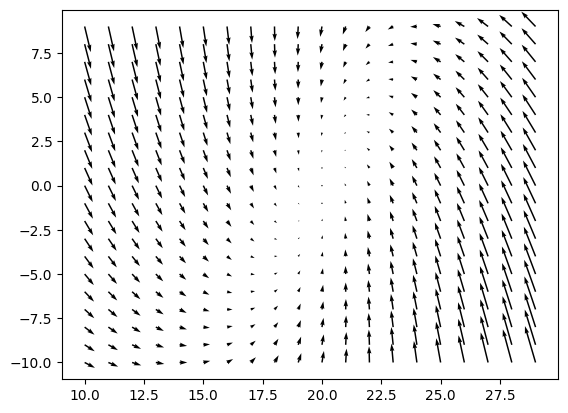

In [129]:
X, Y = np.meshgrid(np.arange(10,30,1), np.arange(-10,10,1))
uxy = ufuncify((v, h), Sys_2d[0])
vxy = ufuncify((v, h), Sys_2d[1])
plt.figure()
plt.quiver(X, Y, uxy(X, Y), vxy(X, Y))